# Multi objective optimization post-processing analysis

In [1]:
using Revise
using FUSE
using IMAS
using JLD2
using Plots;
using Metaheuristics;
gr();

## Process data

### Choose run directory

In [2]:
result_path = "exploratory/opt_betaN_cost__Solovev_Kr_flattop24_HTS0.1_qpol2.75_A3.5_Zeff2.0/"

result_path = "exploratory/opt_betaN_cost__Solovev_Kr_flattop24_HTS0.1_A3.5_Zeff2.0/"
result_path = "exploratory/opt_betaN_cost__Solovev_Kr_flattop48_HTS0.1_A3.5_Zeff2.0/"

run_dir = "gen_runs5"


"gen_runs5"

### Read and/or write cache

In [3]:

cache_path = joinpath(result_path, run_dir)
all_dirs = filter(isdir, sort(readdir(cache_path; join=true)))
println(length(all_dirs))

dirs = sort(filter(x -> !isfile(joinpath(x, "error.txt")), all_dirs))
println(length(dirs))

IMAS.update_ExtractFunctionsLibrary!(); # to pick up any ongoing development to extract function library
outputs = FUSE.extract(dirs; filter_invalid=:cols, cache=joinpath(cache_path, "extract.csv"), read_cache=true, write_cache=true);


128
127


Progress: 100%|███████████████████████████| Time: 0:00:37 ( 0.29  s/it)
[ Info: Written cache file with 127 results


In [4]:
dd, ini, act = FUSE.load(dirs[end]);

┌ Error: reading act.ActorDivertors.impurities : TypeError(:setfield!, "", Union{Missing, Vector{Symbol}}, Float64[])
└ @ SimulationParameters ~/.julia/dev/SimulationParameters/src/utils.jl:92


## Analyze Optimzation results

### Load optimization results file

In [5]:
con = []

for i in range(1,6)

    fname = "result"*string(i)*".jld2"

    try
        @load joinpath(result_path, fname) result
        display("Loaded "*fname)
        for c in result.convergence
            con = [con; c]
        end

    catch
        display("Could not find "*fname)
    end

end

@load joinpath(result_path, "opt_ini.jld2") opt_ini



"Loaded result1.jld2"

"Loaded result2.jld2"

"Loaded result3.jld2"

"Loaded result4.jld2"

"Loaded result5.jld2"

┌ Warning: Opening file with JLD2.MmapIO failed, falling back to IOStream
└ @ JLD2 ~/.julia/packages/JLD2/cHcDY/src/JLD2.jl:287


"Could not find result6.jld2"

1-element Vector{Symbol}:
 :opt_ini

### Parse opt_ini data

In [6]:
fnames = []
for obj_func in opt_ini["objective_functions"]
    name = string(obj_func.name)
    #display(name)
    fnames = [fnames; name]
end
display(fnames)

gnames = []
for con_func in opt_ini["constraint_functions"]
    name = string(con_func.name)
    #display(name)
    gnames = [gnames; name]
end
display(gnames)

xnames = []
for param in opt_ini["free_parameters"]
    name = string(param._name)
    #display(name)
    xnames = [xnames; name]
end
display(xnames)

2-element Vector{Any}:
 "min_capital_cost"
 "min_βn"

9-element Vector{Any}:
 "min_required_power_electric_net"
 "max_ωpe_ωce"
 "min_lh_power_threshold"
 "max_hds03"
 "max_ne_peaking"
 "max_tf_j"
 "max_oh_j"
 "max_tf_stress"
 "max_oh_stress"

6-element Vector{Any}:
 "B0"
 "R0"
 "pressure_core"
 "ip"
 "greenwald_fraction"
 "greenwald_fraction_ped"

### Organize results into dict arrays

In [7]:
db = Dict()
pf = []

# loop over number of generations
for i in 1:1:length(con)
    A = pareto_front(con[i])
    B = con[i].population
    
    # get input values, objective values, and constraint values
    pop_x = reduce(hcat, [j.x for j in B])'
    pop_f = reduce(hcat, [j.f for j in B])'
    pop_g = reduce(hcat, [j.g for j in B])'
    
    # populate objective values 
    for (j,fname) in enumerate(fnames)
        try
            db[fname[5:end]] = hcat(db[fname[5:end]], pop_f[:,j])
        catch
            db[fname[5:end]] = pop_f[:,j]
        end
    end
    
    # populate input values with scale factor
    for (j,xname) in enumerate(xnames)
        try
            db[xname] = hcat(db[xname], pop_x[:,j])
        catch
            db[xname] = pop_x[:,j]
        end
    end
    
    # populate constraint values with conversion factor
    for (j,gname) in enumerate(gnames)
        try
            db[gname[5:end]] = hcat(db[gname[5:end]], pop_g[:,j])
        catch
            db[gname[5:end]] = pop_g[:,j]
        end
    end
    
    # find indices of Pareto-optimal solutions
    #index = zeros(Int,length(B))
    pfi = [findfirst(isequal(a), db[fnames[1][5:end]][:,i]) for a in A[:,1]]
    #index[pfi] .= 1
    pf = [pf; [pfi]]

end


### Rescale constraint values

In [8]:
ini.requirements

requirements{Float64}
├─ power_electric_net ➡ 2.0e8 [W] Net electric power generated by the fusion power plant
├─ flattop_duration ➡ 172800.0 [s] Duration of the flattop (use Inf for steady-state)
├─ log10_flattop_duration ➡ missing Log10 value of the duration of the flattop (use Inf for steady-state). Preferred over
│  `flattop_duration` for optimization studies.
├─ tritium_breeding_ratio ➡ 1.1 Tritium breeding ratio of the whole plant
├─ cost ➡ missing Total FPP cost
├─ ne_peaking ➡ 1.5 On-axis electron density / volume-averaged electron denstiy
├─ q_pol_omp ➡ 2.75e9 [W/m^2] Poloidal heat flux at the outer midplane
├─ lh_power_threshold_fraction ➡ 1.0 Fraction of the LH power threshold
├─ h98y2 ➡ missing H98y2 ITER elmy H-mode confinement scaling factor
├─ hds03 ➡ 1.0 Petty 2003 H-mode thermal energy confinement scaling factor
├─ βn ➡ missing Normalized total plasma beta (MHD)
├─ coil_j_margin ➡ 1.5 Magnet coil J_crit / J_max
└─ coil_stress_margin ➡ 1.0 Magnet coil yield_stress / max

In [9]:
# re-scale constraint values

function scale_max_constraint(value, limit)
    return limit .* (1 .+ value)
end

function scale_min_constraint(value, limit)
    return limit .* (1 .- value)
end

for gname in gnames

    limit = missing

    # get min/max value from dd for common constraints
    if gname == "min_required_power_electric_net"
        limit = ini.requirements.power_electric_net
    elseif gname == "max_ωpe_ωce"
        limit = 1.0
    elseif gname == "min_lh_power_threshold"
        limit = ini.requirements.lh_power_threshold_fraction
    elseif gname == "max_hds03"
        limit = ini.requirements.hds03
    elseif gname == "max_ne_peaking"
        limit = ini.requirements.ne_peaking
    elseif gname == "max_tf_j" || gname == "max_oh_j"
        limit = ini.requirements.coil_j_margin
    elseif gname == "max_tf_stress" || gname == "max_oh_stress"
        limit = ini.requirements.coil_stress_margin
    elseif gname == "max_qpol_omp"
        limit = ini.requirements.q_pol_omp
    end

    # scale 
    if occursin("max", gname)
        db[gname[5:end]] = scale_max_constraint(db[gname[5:end]], limit)
    elseif occursin("min", gname)
        db[gname[5:end]] = scale_min_constraint(db[gname[5:end]], limit)
    end

end

## Visualize Optimization results

### Plot f, x, g evolution

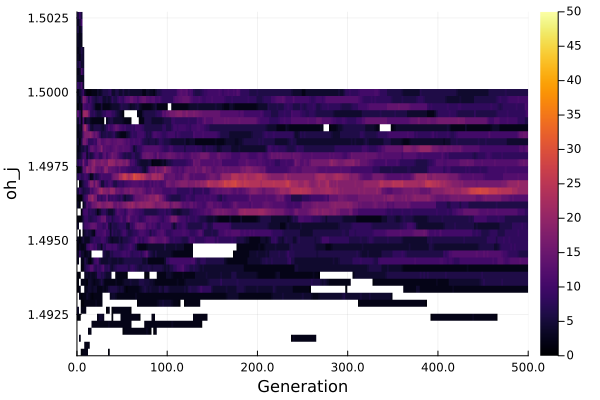

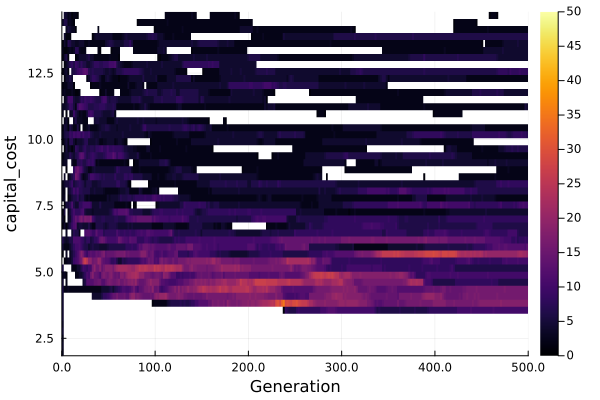

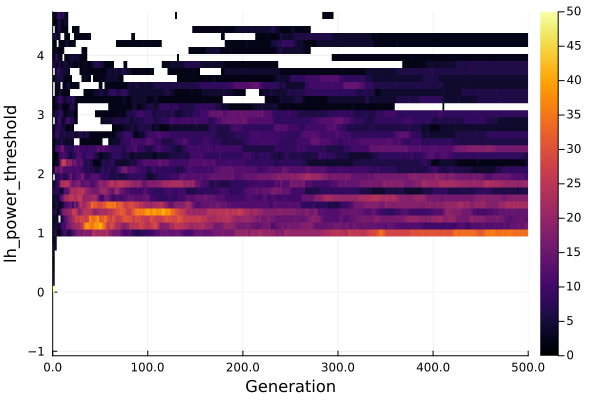

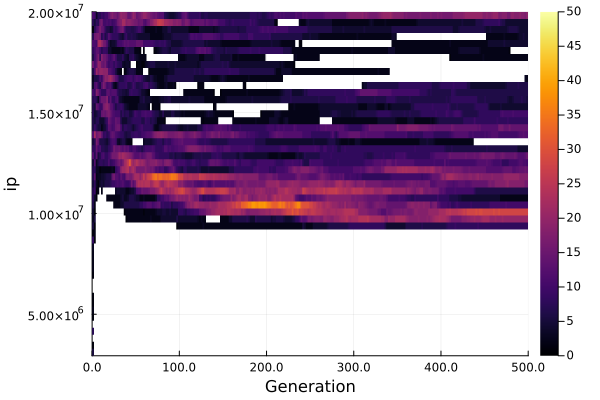

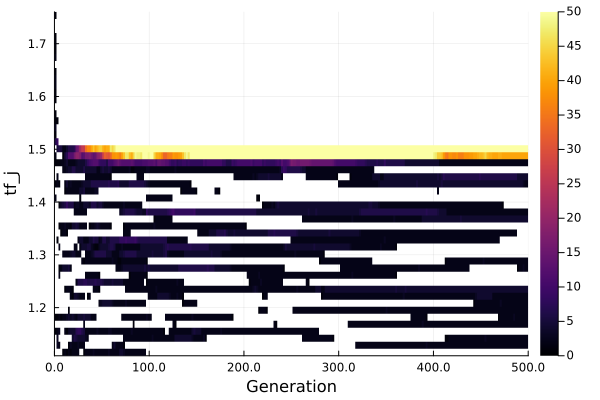

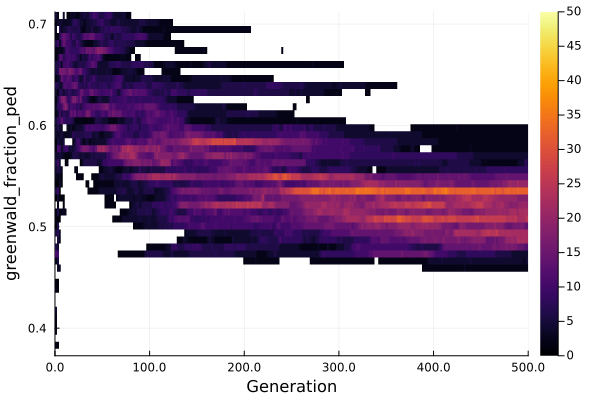

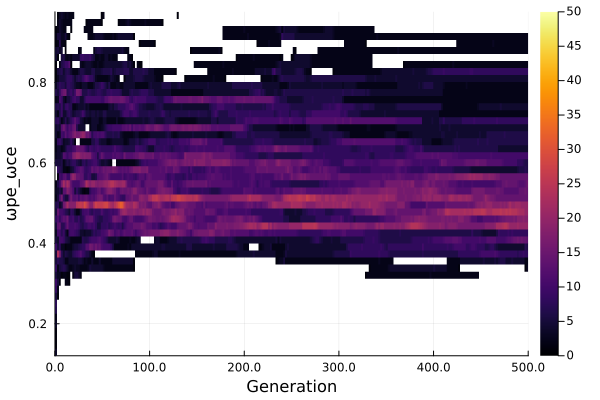

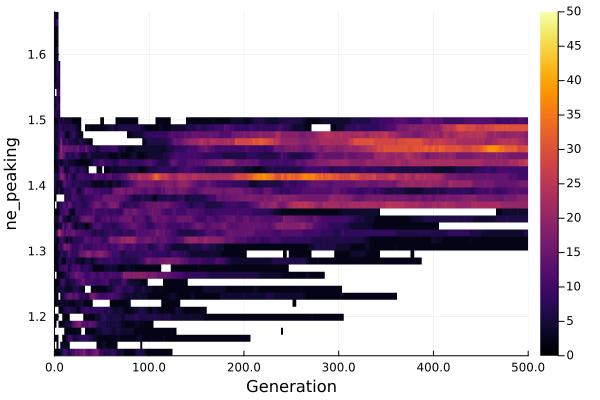

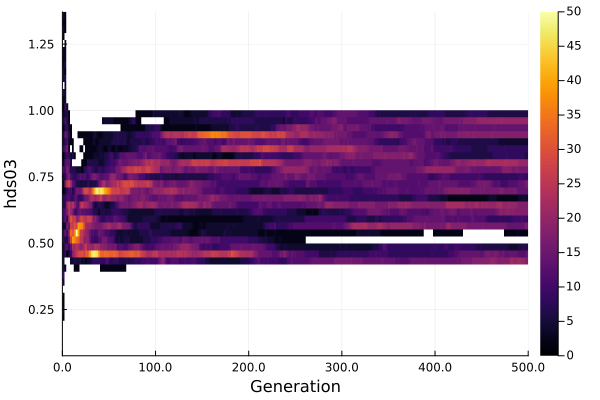

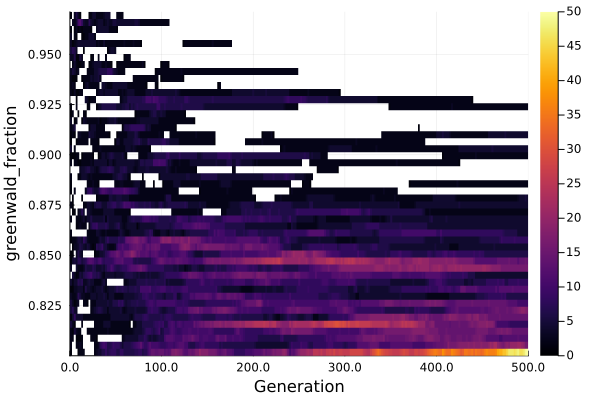

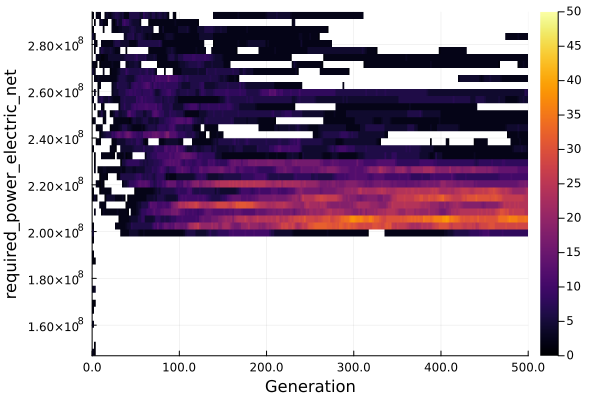

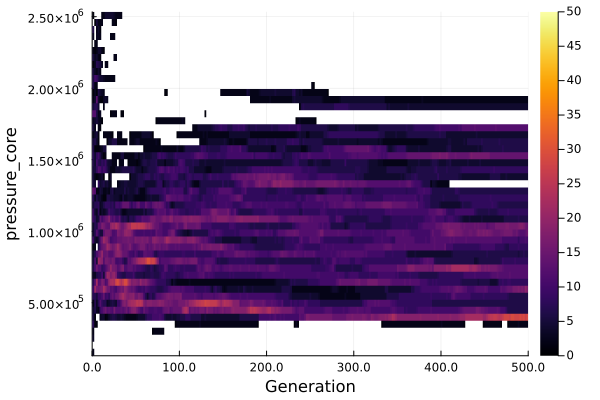

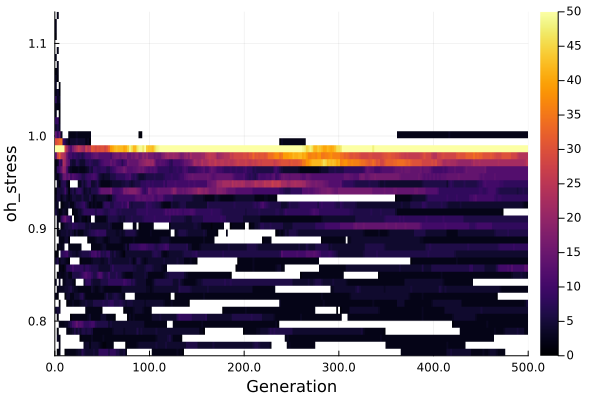

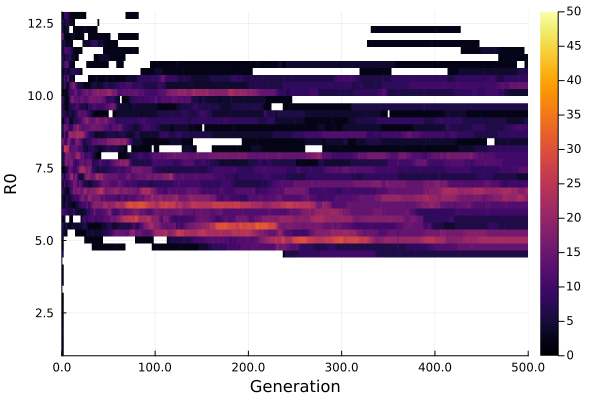

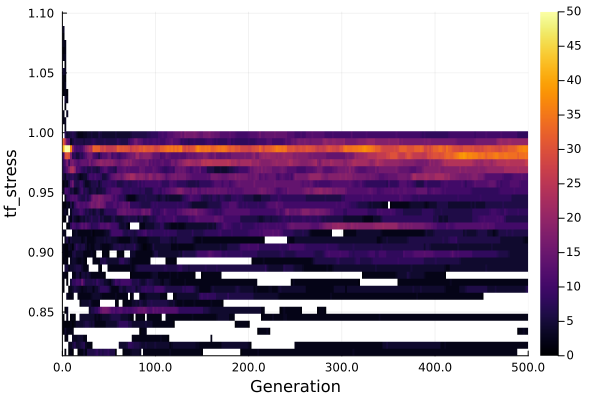

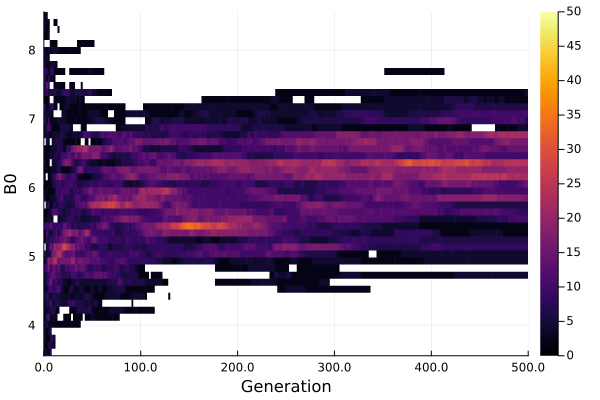

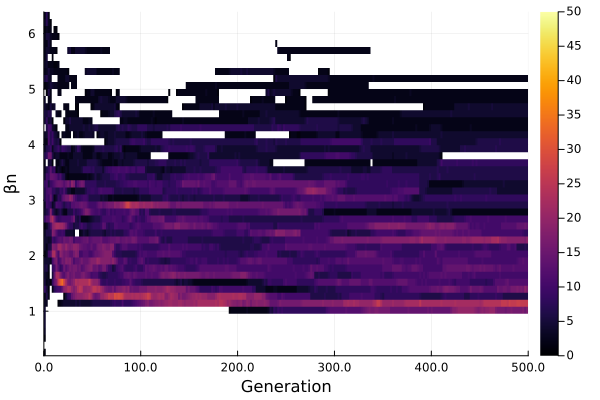

In [10]:
import Statistics
function y_auto_range(y; σ=5, N=50)
    y_nonan = y[@. !isnan.(y)]
    m = Statistics.median(y_nonan)
    s = Statistics.median(Statistics.median(abs.(y_nonan .- m))) * σ
    Y = LinRange(max(m - s, minimum(y_nonan)), min(m + s, maximum(y_nonan)), N)
end

clim = (0,50)
N = 5

for var in keys(db)
    
    y = db[var]
    ngen = size(y)[2]
    X = LinRange(1,length(y),Int(round(ngen/2)))
    yname = var
    
    yflat = vcat(y...)
    Y = y_auto_range(yflat)
    
    p = histogram2d(yflat, bins=(X, Y), ylabel=yname, xlabel="Generation", clim=clim)
    xticks!(LinRange(0,length(y),N+1),[string(x) for x in (LinRange(0,ngen,N+1))])
    display(p)

end



### Define function for scatter plot of ith generation

In [11]:
function scatter_gen(
        db, pf,
        igen,xlabel,ylabel,
        xrange,yrange)
    
    x = db[xlabel][:,igen]
    y = db[ylabel][:,igen]
    
    xpf = x[pf[igen]]
    ypf = y[pf[igen]]
    
    s1 = scatter(x, y, color=:grey, label="Population", alpha=0.7)
    s2 = scatter!(s1, xpf, ypf, color=:red, label="Pareto-optimal")
    s = plot(s2, size=(450, 450), title="Generation: "*string(igen), xlabel=xlabel, ylabel=ylabel, xrange=xrange, yrange=yrange) 
    
end

scatter_gen (generic function with 1 method)

### Make gif of population evolution

[ Info: Saved animation to /fusion/ga/projects/ird/ptp/weisbergd/julia/dev/FUSE/playground/weisberg_FPP_opt/exploratory/opt_betaN_cost__Solovev_Kr_flattop48_HTS0.1_A3.5_Zeff2.0/βn_B0.gif


Plots.AnimatedGif("/fusion/ga/projects/ird/ptp/weisbergd/julia/dev/FUSE/playground/weisberg_FPP_opt/exploratory/opt_betaN_cost__Solovev_Kr_flattop48_HTS0.1_A3.5_Zeff2.0/βn_B0.gif")
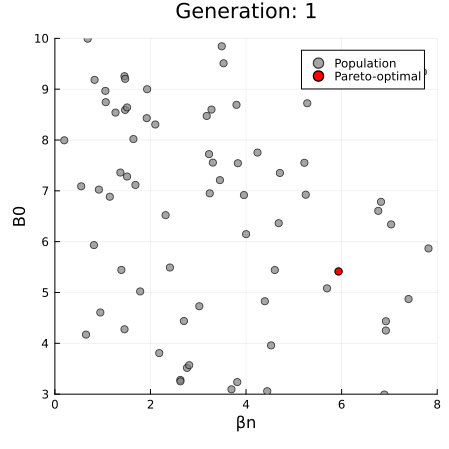

In [25]:
min_Pelectric = 200.0 # MW
min_fLH = 1.0
max_Sn = 1.5
max_qpol = 2.75e3 # MW/m^2
max_ds03 = 1.0
max_accessEC = 1.0
min_TF_j_margin = 1.5
min_OH_j_margin = 1.5
min_TF_stress_margin = 1.0
min_OH_stress_margin = 1.0


xlabel = "βn"
xrange = (0,8)

ylabel = "capital_cost"
yrange = (0.0, 20.0)

ylabel = "B0"
yrange = (3.0, 10)

gen_list = 1:1:length(con)
gen_list = vcat(gen_list,repeat([length(con)],100))

a = @animate for igen in gen_list
    s = scatter_gen(db, pf, igen, xlabel, ylabel, xrange, yrange)
end

g = gif(a, joinpath(result_path, xlabel*"_"*ylabel*".gif"), fps=30)
display(g)

### Static plots

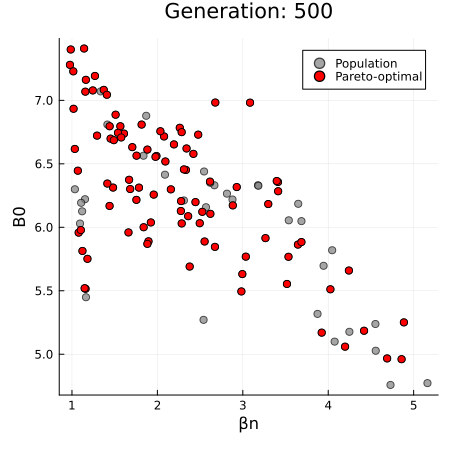

In [27]:
xlabel = "βn"

ylabel = "capital_cost"
ylabel = "hds03"
ylabel = "R0"
ylabel = "B0"
#ylabel = "greenwald_fraction"
#ylabel = "ip"
#ylabel = "required_power_electric_net"

xrange = :missing
yrange = :missing

igen = gen_list[end]

s = scatter_gen(db, pf, igen, xlabel, ylabel, xrange, yrange)

#scatter!(s,outputs[:,"βn_MHD"],outputs[:,"Prad_tot"],markershape=:+,color=:black)



In [14]:
for name in names(outputs)
    println(name)
end

1/ϵ
<Bpol>
<P>
<Te>
<Ti>
<ne>
<zeff>
B0
Bpol_omp
H98y2
Hds03
Nw_peak
OH_j_margin
OH_material
OH_max_b
OH_stress_margin
P/R0
P0
P0/<P>
PB/R0
PBp/R0
PF_material
PLH
Paux_tot
Pec
Pelectric_net
Pfusion
Prad_tot
Psol
Qfusion
Qplant
R0
Surface
TBR
TF_j_margin
TF_material
TF_max_b
TF_stress_margin
Te0
Te0/<Te>
Ti0
Ti0/<Ti>
Volume
a
capital_cost
dir
fGW
flattop
ip
ip_aux
ip_bs
ip_bs_aux_ohm
ip_ni
ip_ohm
levelized_CoE
ne0
ne0/<ne>
ne_ped
q95
qpar
qpol
zeff_ped
βn
βn_MHD
βn_th
βpol_MHD
βtor_MHD
δ
ζ
ηthermal_cycle
κ
λq
τe


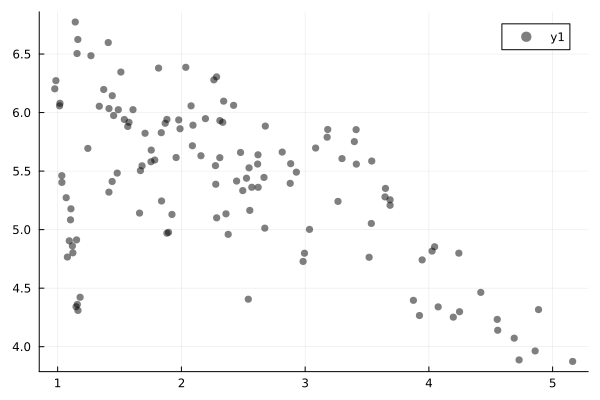

In [24]:
scatter(outputs[:,"βn_MHD"],outputs[:,"Nw_peak"],markershape=:circle,color=:black, alpha=0.5)
#scatter(outputs[:,"βn_MHD"],outputs[:,"qpol"],markershape=:circle,color=:black, alpha=0.5)
#scatter(outputs[:,"βn_MHD"],outputs[:,"PBp/R0"],markershape=:circle,color=:black, alpha=0.5)
scatter(outputs[:,"βn_MHD"],outputs[:,"q95"],markershape=:circle,color=:black, alpha=0.5)
#scatter(outputs[:,"βn_MHD"],outputs[:,"βn_th"] ./ outputs[:,"βn_MHD"],markershape=:circle,color=:black, alpha=0.5)

#scatter(outputs[:,"βn_MHD"],outputs[:,"TBR"],markershape=:circle,color=:black, alpha=0.5)


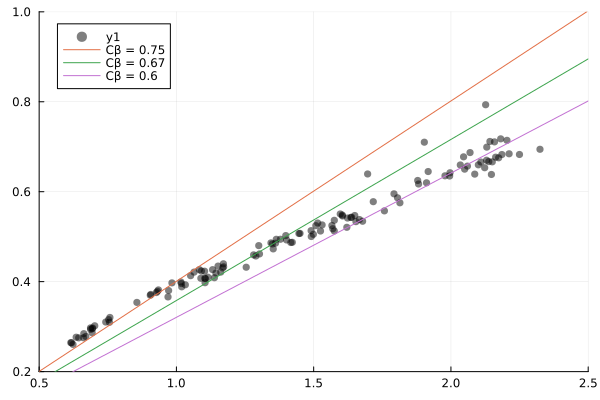

In [16]:
s = scatter(outputs[:,"βpol_MHD"],outputs[:,"ip_bs"]./outputs[:,"ip_bs_aux_ohm"],markershape=:circle,color=:black, alpha=0.5)
x = LinRange(0,3,55)
plot!(s,x,0.75*x/sqrt(3.5),label="Cβ = 0.75")
plot!(s,x,0.67*x/sqrt(3.5),label="Cβ = 0.67")
plot!(s,x,0.6*x/sqrt(3.5),label="Cβ = 0.6")
plot!(s,xrange=(0.5,2.5),yrange=(0.2,1.0))

In [17]:
IMAS.Bpol(2.0, 1.85, 15.0 * 1e6)

1.0087239592577544

In [18]:
100*5.3/6.2

85.48387096774194